## Heat equation

$ \displaystyle
  \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$

$ \displaystyle
  \alpha = 0.061644
$

$ \displaystyle
  \frac{\partial u(0, t)}{\partial x} = 0
$

$ \displaystyle
  \frac{\partial u(1, t)}{\partial x} = 0
$

$ \displaystyle
  u(x, 0) = \cos(2 x)
$

In [1]:
import sympy as sp
from sympy.core.symbol import Symbol
from sympy.core.expr import Expr
from util.print import d
import matplotlib.pyplot as plt
import jax.numpy as np

from typing import Callable, Tuple, List

In [2]:
alpha = 0.061644

In [3]:
# main equation loss
def loss_1(uhat, duhat_dx, duhat_dt, d2uhat_dx2, d2uhat_dt2, x, t):
  term = duhat_dt - alpha * d2uhat_dx2
  return sp.Pow(term, 2, evaluate=False)

# boundary condition loss x=0
def loss_2(uhat, duhat_dx, duhat_dt, d2uhat_dx2, d2uhat_dt2, x, t):
  term = sp.diff(uhat, x).subs(x, 0)
  return sp.Pow(term, 2, evaluate=False)

# boundary condition loss x=1
def loss_3(uhat, duhat_dx, duhat_dt, d2uhat_dx2, d2uhat_dt2, x, t):
  term = sp.diff(uhat, x).subs(x, 1)
  return sp.Pow(term, 2, evaluate=False)

# initial condition loss t=0
def loss_4(uhat, duhat_dx, duhat_dt, d2uhat_dx2, d2uhat_dt2, x, t):
  term = uhat.subs(t, 0) - sp.cos(2*x)
  return sp.Pow(term, 2, evaluate=False)

In [4]:
x, t = sp.symbols('x t')
uhat, duhat_dx, duhat_dt, d2uhat_dx2, d2uhat_dt2 = sp.symbols(r'\hat{u}, \frac{d\hat{u}}{dx} \frac{d\hat{u}}{dt} \frac{d^2\hat{u}}{dx^2} \frac{d^2\hat{u}}{dt^2}')

def symbolic_loss(
  loss_and_hyperpar: List[Tuple[Callable[[Expr, Expr, Expr, Expr, Expr, Symbol, Symbol], Expr], float]]
) -> Expr:  
  total_sum = 0
  for loss_func, hyperpar in loss_and_hyperpar:
    val = loss_func(uhat, duhat_dx, duhat_dt, d2uhat_dx2, d2uhat_dt2, x, t)
    total_sum += hyperpar * val
  
  return total_sum

def evaluate_loss(loss_model: Expr, symbolic_u: Expr) -> Expr:
  symbolic_duhat_dx = sp.diff(symbolic_u, x)
  symbolic_duhat_dt = sp.diff(symbolic_u, t)
  symbolic_d2uhat_dx2 = sp.diff(symbolic_u, x, 2)
  symbolic_d2uhat_dt2 = sp.diff(symbolic_u, t, 2)
  return loss_model.subs([(uhat, symbolic_u), (duhat_dx, symbolic_duhat_dx), (duhat_dt, symbolic_duhat_dt), (d2uhat_dx2, symbolic_d2uhat_dx2), (d2uhat_dt2, symbolic_d2uhat_dt2)])

In [5]:
one_uhat_model = sp.cos(2*x)/t+sp.log(t)*0.18

loss_model = symbolic_loss([(loss_1, 1), (loss_2, 0.5), (loss_3, 0.5), (loss_4, 0.5)])
loss = evaluate_loss(loss_model, one_uhat_model)

In [6]:
loss

(0.246576*cos(2*x)/t + 0.18/t - cos(2*x)/t**2)**2 + 0.5*(0.18*log(t) - cos(2*x) + cos(2*x)/t)**2

In [10]:
sp.integrate(loss, (x, 0, 1))

0.0162*log(t)**2 - 0.09*log(t)*sin(2) + 0.125*sin(2)*cos(2) + 0.25*cos(2)**2 + 0.25*sin(2)**2 + 0.09*log(t)*sin(2)/t - 0.5*sin(2)**2/t - 0.5*cos(2)**2/t - 0.25*sin(2)*cos(2)/t + 0.140199930944*sin(2)*cos(2)/t**2 + 0.0324/t**2 + 0.04438368*sin(2)/t**2 + 0.280399861888*cos(2)**2/t**2 + 0.280399861888*sin(2)**2/t**2 - 0.246576*sin(2)**2/t**3 - 0.18*sin(2)/t**3 - 0.246576*cos(2)**2/t**3 - 0.123288*sin(2)*cos(2)/t**3 + 0.25*sin(2)*cos(2)/t**4 + 0.5*cos(2)**2/t**4 + 0.5*sin(2)**2/t**4

In [34]:
lambdify_modules = {
  "exp": np.exp,
  "sin": np.sin,
  "cos": np.cos,
  "Min": np.minimum,
  "Max": np.maximum,
  "fmin": np.minimum,
  "fmax": np.maximum,
  "min": np.minimum,
  "max": np.maximum,
  "log": np.log,
  "Abs": np.abs,
  "abs": np.abs
}

In [8]:
x, t, a = sp.symbols(r"x t \alpha")

In [18]:
u = sp.Function('u')(x, t)

In [19]:
eq = a * sp.diff(u, x, 2) - sp.diff(u, t)

# Testing

In [39]:
f = sp.lambdify([x], sp.cos(2*x), modules=lambdify_modules)
xspace = np.linspace(0, 1)

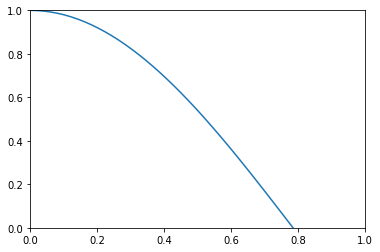

In [45]:
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.plot(xspace, f(xspace))

In [109]:
yhat1 = sp.cos(2*x)/t+sp.log(t)*0.18
yhat1

0.18*log(t) + cos(2*x)/t

In [110]:
ftest = sp.lambdify([x, t], yhat1, modules=lambdify_modules)

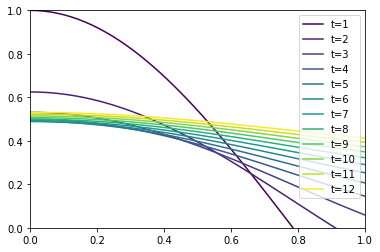

In [108]:
colors = plt.cm.viridis(np.linspace(0, 1, 12))
plt.xlim(0, 1)
plt.ylim(0, 1)
for ti in range(1, 13):
  plt.plot(xspace, ftest(xspace, ti), color=colors[ti-1], label=f"t={ti}")

plt.legend()
plt.show()